In [ ]:
username = 'MarcelloCeresini'
repository = 'QuestionAnswering'

# COLAB ONLY CELLS
try:
    import google.colab
    IN_COLAB = True
    !pip3 install transformers
    !git clone https://www.github.com/{username}/{repository}.git
    #from google.colab import drive
    #drive.mount('/content/drive/')
    %cd /content/QuestionAnswering/src
    using_TPU = True    # If we are running this notebook on Colab, use a TPU
    # Google cloud credentials
    %env GOOGLE_APPLICATION_CREDENTIALS=/content/drive/MyDrive/Uni/Magistrale/NLP/Project/nlp-project-338723-0510aa0a4912.json
except:
    IN_COLAB = False
    using_TPU = False   # If you're not on Colab you probably won't have access to a TPU

# Description

In this notebook, we will try to implement the architecture detailed in [Dense Passage Retrieval for Open-Domain Question Answering](https://arxiv.org/pdf/2004.04906.pdf). 

The idea is that we have a corpus of documents $C = {p_1, p_2, \dots, p_M}$ where each passage $p_i$ can be viewed as a sequence of tokens $w_1^{(i)}, w_2^{(i)}, \dots, w_{|p_i|}^{(i)}$ and given a question $q$ we want to find the sequence of tokens $w_s^{(i)}, w_{s+1}^{(i)}, \dots, w_{e}^{(i)}$ from one of the passage $i$ that can answer the question.

In order to find the passage $i$ we need an efficient **Retriever** (i.e. a function $R: (q, C) \rightarrow C_F$ where $C_F$ is a very small set of $k$ documents that have a high correlation with the query.)

In the Tf-Idf example, the retriever was simply a function that returned the top score obtained by computing the vector cosine similarity between the query and all other documents. The problem with this approach is that it is not very efficient. Tf-Idf is a **sparse** document/query representation, thus computing a multitude of dot products between these very long vectors can be expensive.

The paper cited above proposes a **dense** representation instead. It uses a Dense Encoder $E_P$ which maps all paragraphs to $d$-dimensional vectors. These vectors are stored in a database so that they can be efficiently retrieved. 

At run-time, another Dense Encoder $E_Q$ is used: it maps the input question to a vector with the same dimensionality $d$. Then, a similarity score is computed between the two representations:

$sim(p,q) = E_Q(q)^\intercal E_P(p)$

In the paper, $E_Q$ and $E_P$ are two independent BERT transformers and the $d$-dimensional vector is the **output at the $\texttt{[CLS]}$ token** (so, $d = 768$).
- This leaves open the possibility to use a larger dimensionality (eg. concatenating the output at multiple blocks like we did for the QA task).

<!-- The $d$-dimensional representations of the $M$ passages are indexed using [FAISS](https://github.com/facebookresearch/faiss), an efficient, open-source library for similarity search and clustering of dense vectors developed at Facebook AI.  -->
At run-time, we simply compute $v_q = E_Q(q)$ and retrieve the top $k$ passages with embeddings closest to $v_q$.

In this case, training the network means solving a **metric learning** problem: the two BERT networks need to learn an **effective vector space** such that relevant pairs of questions and passages are close, while irrelevant pairs are placed further away. In this problem we usually build a **training instance $D$** as ${(q_i, p_i^+, p_{i,1}^-, p_{i,2}^-, \dots, p_{i,n}^-)}^m_{i=1}$, where question $q$ is paired with a relevant (positive) passage $p_i^+$ and $n$ irrelevant (negative) passages. Then, the loss function is the negative log-likelihood of the positive passage:

$L(q_i, p_i^+, p_{i,1}^-, p_{i,2}^-, \dots, p_{i,n}^-) = -\log\frac{e^{sim(q_i, p_i^+)}}{e^{sim(q_i, p_i^+)} + \sum_{j=1}^n e^{sim(q_i, p_{i,j}^-)}}$

It's easy to find the positive paragraph, but choosing the negatives is quite important. In particular, the paper proposes different ways for sampling the negatives:
- Random: a negative is any random passage in the corpus
- TF-IDF (The paper uses a variant, BM25): the negatives are the top passages (not containing the answer) returned by a TF-IDF search
- Gold: the negatives are positives for other questions in the mini-batch. For the researchers, this is the best negative-mining option, because it's the most efficient and also it makes a batch a complete unit of learning (we learn the relationship that each question in the batch has with the other paragraphs).

The Gold method allows the **in-batch negatives** technique: assuming to have a batch size of $B$, then we collect two $B \times d$ matrices (one for questions, one for their positive paragraphs). Then, we compute $S = QP^\intercal$ which is a $B \times B$ matrix of **similarity scored** between each question and paragraph. This matrix can directly be used for training: any ($q_i, p_j$) pais where $i = j$ is considered to be a positive example, while it's negative otherwise. In total there will be $B$ training instances per batch, each with $B-1$ negative passages. 

# Configuration

## Imports

In [2]:
import os
import numpy as np
import random
from tqdm import tqdm
from functools import partial
tqdm = partial(tqdm, position=0, leave=True)
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import Sequence
from typing import List, Union, Dict, Tuple
from transformers import BertTokenizerFast, DistilBertTokenizerFast, \
                         TFBertModel, TFDistilBertModel
import utils

RANDOM_SEED = 42
MAX_SEQ_LEN = 512
BERT_DIMENSIONALITY = 768

np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

### TPU check
The training could be made faster if we use the cloud GPUs offered by Google on Google Colab. Since TPUs require manual intialization and other oddities, we check multiple times throughout the notebook what kind of hardware we are running the code on.

In [3]:
if using_TPU:
    try: 
        resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
        tf.config.experimental_connect_to_cluster(resolver)
        # This is the TPU initialization code that has to be at the beginning.
        tf.tpu.experimental.initialize_tpu_system(resolver)
        print("All devices: ", tf.config.list_logical_devices('TPU'))
        strategy = tf.distribute.TPUStrategy(resolver)
    except:
        print("TPUs are not available, setting flag 'using_TPU' to False.")
        using_TPU = False
        print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
else:
    print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

BATCH_SIZE = 8 if not using_TPU else 64

TPUs are not available, setting flag 'using_TPU' to False.
Num GPUs Available:  1


In [4]:
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive/')
    checkpoint_dir = '/content/drive/MyDrive/Uni/Magistrale/NLP/Project/weights/training_dpr/'
    datasets_dir = '/content/drive/MyDrive/Uni/Magistrale/NLP/Project/datasets/dpr/'
else:
    # Create the folder where we'll save the weights of the model
    checkpoint_dir = os.path.join("data", "training_dpr")
    datasets_dir = os.path.join("data", "training_dpr", "dataset")

os.makedirs(checkpoint_dir, exist_ok=True)
os.makedirs(datasets_dir, exist_ok=True)

Mounted at /content/drive/


## Allowed operations

In [5]:
ANALYSE_TOKENIZATIONS = True    # Tokenises all paragraphs and showcases a simple analysis
                                # for reducing the length of the sequence. Runs in less 
                                # than a few minutes on any architecture.

OVERWRITE_DATASETS = False      # Best to be run on GPU, takes about half an hour.
                                # It saves a new copy of the pre-tokenized
                                # question-paragraph pair on Google Drive.
                                # The copy should then be uploaded to GCloud into
                                # the bucket allocated for the project to be used by
                                # TPUs.

DO_TRAINING = True              # Best to be run on TPU, takes about 2 hours.
                                # It trains the model and saves a copy of the 
                                # last weights on Google Drive. When run on GPU
                                # It also saves checkpoints and Tensorboard data,
                                # but it takes over 4 hours to do a single epoch,
                                # so it's impossible to run it on Colab.

OVERRIDE_REPRESENTATIONS = True  # Best to be run on GPU, it takes about 30 minutes.
                                 # It produces representations of all paragraphs
                                 # using the trained model_p as a large NumPy array
                                 # that is stored on Google Drive at the end.

RUN_ACCURACY_ANALYSIS = True    # Best to be run on GPU, takes about an hour
                                # It analyzes the paragraph retrieval capability
                                # of the model with top-1 and top-5 accuracy.

## Variables

We define all the paths.

In [6]:
ROOT_PATH = os.path.dirname(os.getcwd())
TRAINING_FILE = os.path.join(ROOT_PATH, 'data', 'training_set.json')
VALIDATION_FILE = os.path.join(ROOT_PATH, 'data', 'validation_set.json')
TEST_FILE = os.path.join(ROOT_PATH, 'data', 'dev_set.json')

We collect the training, validation and testing questions and paragraphs.

In [7]:
train_paragraphs_and_questions = utils.read_question_set(TRAINING_FILE)['data']
val_paragraphs_and_questions = utils.read_question_set(VALIDATION_FILE)['data']
test_paragraphs_and_questions = utils.read_question_set(TEST_FILE)['data']

# Remove the validation set from the train set
train_paragraphs_and_questions = [article for article in train_paragraphs_and_questions \
                                  if article not in val_paragraphs_and_questions]

def get_questions_and_paragraphs(dataset):
    questions = [{
            'qas': qas,
            'context_id': (i,j)    # We also track the question's original context and paragraph indices so to have a ground truth
        }
        for i in range(len(dataset))
        for j, para in enumerate(dataset[i]['paragraphs'])
        for qas in para['qas']
    ]

    paragraphs = [{
            'context': para['context'],
            'context_id': i
        }
        for i in range(len(dataset))
        for para in dataset[i]['paragraphs']
    ]

    return questions, paragraphs

train_questions, train_paragraphs = get_questions_and_paragraphs(train_paragraphs_and_questions)
val_questions, val_paragraphs = get_questions_and_paragraphs(val_paragraphs_and_questions)
test_questions, test_paragraphs = get_questions_and_paragraphs(test_paragraphs_and_questions)

print(f"Number of training questions: {len(train_questions)}")
print(f"Number of training paragraphs: {len(train_paragraphs)}")
print()
print(f"Number of val questions: {len(val_questions)}")
print(f"Number of val paragraphs: {len(val_paragraphs)}")
print()
print(f"Number of test questions: {len(test_questions)}")
print(f"Number of test paragraphs: {len(test_paragraphs)}")

Number of training questions: 65064
Number of training paragraphs: 13975

Number of val questions: 22535
Number of val paragraphs: 4921

Number of test questions: 10570
Number of test paragraphs: 2067


We create the two different DistilBert models for encoding and test them on a random question/paragraph.

In [8]:
tokenizer_distilbert = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

model_q, model_p = TFDistilBertModel.from_pretrained('distilbert-base-uncased'), \
                   TFDistilBertModel.from_pretrained('distilbert-base-uncased')

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/347M [00:00<?, ?B/s]

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_transform', 'vocab_projector', 'activation_13', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.
Some layers from the model checkpoint at distilbert-base-uncased were no

What is the ideal maximum length of a sequence of tokens?

In [9]:
if ANALYSE_TOKENIZATIONS:
    lens = []
    for paragraph in tqdm(train_paragraphs):
        emb = tokenizer_distilbert(paragraph['context'], return_tensors='np')
        tokens = emb['attention_mask'].shape[1]
        lens.append(tokens)
    print(f"Total n. of paragraphs: {len(train_paragraphs)}")
    for i in range(350, 500, 10):
        print(f"Only {np.sum(np.asarray(lens) > i)} are truncated when using {i} max tokens ({np.sum(np.asarray(lens) > i) / len(train_paragraphs)*100}%)")

100%|██████████| 13975/13975 [00:06<00:00, 2177.61it/s]

Total n. of paragraphs: 13975
Only 184 are truncated when using 350 max tokens (1.3166368515205724%)
Only 156 are truncated when using 360 max tokens (1.1162790697674418%)
Only 132 are truncated when using 370 max tokens (0.9445438282647585%)
Only 119 are truncated when using 380 max tokens (0.851520572450805%)
Only 100 are truncated when using 390 max tokens (0.7155635062611807%)
Only 84 are truncated when using 400 max tokens (0.6010733452593918%)
Only 68 are truncated when using 410 max tokens (0.48658318425760283%)
Only 58 are truncated when using 420 max tokens (0.4150268336314848%)
Only 46 are truncated when using 430 max tokens (0.3291592128801431%)
Only 39 are truncated when using 440 max tokens (0.27906976744186046%)
Only 35 are truncated when using 450 max tokens (0.25044722719141327%)
Only 30 are truncated when using 460 max tokens (0.2146690518783542%)
Only 28 are truncated when using 470 max tokens (0.2003577817531306%)
Only 27 are truncated when using 480 max tokens (0.19

To reduce memory consumption, we can:
- Truncate sequences at something like 380 tokens (less than 1% of the total training paragraphs would be cut with this decision)
- Reduce the dimensionality of Bert/DistilBert's output to `BERT_DIMENSIONALITY` (instead of the default of 768).

In [10]:
MAX_SEQ_LEN = 512
BERT_DIMENSIONALITY = 768

If we decide to reduce the dimensionality, we can add a `Dense` layer on top of the encoder. This layer reduces the dimension of the output to whatever we need.

In [11]:
class ReducedDistilBertModel(keras.Model):
    def __init__(self, distilbert_model):
        super(ReducedDistilBertModel, self).__init__()
        self.distilbert_model = distilbert_model
        self.reduction_layer = keras.layers.Dense(BERT_DIMENSIONALITY, 
                                                  activation='gelu')

    def call(self, inputs):
        hidden_state = self.distilbert_model(inputs).last_hidden_state
        # We introduce a dense layer that simply reduces the dimensionality of distilbert
        return self.reduction_layer(hidden_state)

model_q = ReducedDistilBertModel(model_q)
model_p = ReducedDistilBertModel(model_p)

Let's try this model on a test question:

In [12]:
test_question = train_questions[0]['qas']['question']
print(f"Testing on a simple question. \nQuestion: {test_question}")
inputs_test = tokenizer_distilbert(test_question, return_tensors="tf")
outputs = model_q(inputs_test)

# As a representation of the token we use the last hidden state at the [CLS] token (the first one)
test_q_repr = outputs[0,0,:]
print(f"Representation dimensionality: {test_q_repr.shape}")

Testing on a simple question. 
Question: To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?
Representation dimensionality: (768,)


# Dataset creation

First of all, we need to train our models. To do that, we need to create a dataset that feeds batches of questions and positive and negative paragraphs to our model. The model is then used to compute the representations of the questions/paragraphs and through the representations we can compute the similarities and correct the learnt distributions from the encoder models.

For the dataset, we use the `tf.data.Dataset` API. In particular, we first create the dataset in a `.proto` file which contains all the information in a byte format. The file is then uploaded on Google Cloud, where it can easily be accessed all future times. This is the only working way to have a large dataset accessible from the TPU.

In [13]:
def get_paragraph_from_question(qas, dataset):
    # Returns the ground truth paragraph for a question.
    i,j = qas['context_id']
    return dataset[i]['paragraphs'][j]

def pre_tokenize_data(questions, dataset, tokenizer):
    # Pre-tokenizes questions and paragraphs
    tokenized_questions = [
        dict(tokenizer(questions[i]['qas']['question'], 
            max_length = MAX_SEQ_LEN, truncation = True, 
            padding = 'max_length'))
        for i in tqdm(range(len(questions)))]
    tokenized_paragraphs = [
        dict(tokenizer(get_paragraph_from_question(
                    questions[i], dataset
                )['context'], max_length = MAX_SEQ_LEN, 
            truncation = True, padding = 'max_length',
            return_offsets_mapping = True))             # For the paragraphs we need the offset mappings too
        for i in tqdm(range(len(questions)))]
    return tokenized_questions, tokenized_paragraphs

def find_start_end_token_one_hot_encoded(
    answers: Dict, 
    offsets: List[Tuple[int]]) -> Dict:
    '''
    This function returns the starting and ending token of the answer, 
    already one hot encoded and ready for binary crossentropy.
    Inputs:
        - answers: `List[Dict]` --> for each question, a list of answers.
            Each answer contains:
            - `answer_start`: the index of the starting character
            - `text`: the text of the answer, that we exploit through the 
                number of chars that it contains
        - offsets: `List[Tuple[int]]` --> the tokenizer from HuggingFace 
            transforms the paragraph into a sequence of tokens. 
            Offsets keeps track of the character start and end indexes for each token.
   
    Output:
        - result: `Dict` --> each key contains only one array, the one-hot 
            encoded version of, respectively, the start and end token of 
            the answer in the sentence (question+context)
    '''
    result = {
        "out_S": np.zeros(len(offsets), dtype=np.int32),
        "out_E": np.zeros(len(offsets), dtype=np.int32)
    } 
    for answer in answers:
        starting_char = answer['answer_start']
        answer_len = len(answer['text'])
        # We skip the first token, [CLS], that has (0,0) as a tuple
        for i in range(1, len(offsets)):
            # Check if starting char is within the indexes
            if (starting_char >= offsets[i][0]) and \
                (starting_char <= offsets[i][1]):
                result["out_S"][i] += 1
            # If the ending char (starting + length -1) is in the interval, 
            # same as above.
            if (starting_char + answer_len - 1 >= offsets[i][0]) and \
                (starting_char + answer_len - 1 < offsets[i][1]):
                result["out_E"][i] += 1
                break
    return result

def decode_fn(record_bytes):
    # Reads one element from the dataset (as bytes) and decodes it in a tf.data Dataset element.
    example = tf.io.parse_single_example(
      # Data
      record_bytes,
      # Schema
      {"question__input_ids": tf.io.FixedLenFeature(shape=(MAX_SEQ_LEN,), dtype=tf.int64),
       "question__attention_mask": tf.io.FixedLenFeature(shape=(MAX_SEQ_LEN,), dtype=tf.int64),
       "question__index": tf.io.FixedLenFeature(shape=(), dtype=tf.int64),
       "answer__out_s": tf.io.FixedLenFeature(shape=(MAX_SEQ_LEN,), dtype=tf.int64),
       "answer__out_e": tf.io.FixedLenFeature(shape=(MAX_SEQ_LEN,), dtype=tf.int64),
       "paragraph__input_ids": tf.io.FixedLenFeature(shape=(MAX_SEQ_LEN,), dtype=tf.int64),
       "paragraph__attention_mask": tf.io.FixedLenFeature(shape=(MAX_SEQ_LEN,), dtype=tf.int64),
       "paragraph__tokens_s": tf.io.FixedLenFeature(shape=(MAX_SEQ_LEN,), dtype=tf.int64),
       "paragraph__tokens_e": tf.io.FixedLenFeature(shape=(MAX_SEQ_LEN,), dtype=tf.int64),
       "context__index": tf.io.FixedLenFeature(shape=(), dtype=tf.int64),
       "paragraph__index": tf.io.FixedLenFeature(shape=(), dtype=tf.int64)})
    return {
      "questions": {'input_ids': example['question__input_ids'],
                    'attention_mask': example['question__attention_mask'],
                    'index': example['question__index']},
      "answers":   {'out_s': example['answer__out_s'],
                    'out_e': example['answer__out_e']},
      "paragraphs":{'input_ids': example['paragraph__input_ids'],
                    'attention_mask': example['paragraph__attention_mask'],
                    'tokens_s': example['paragraph__tokens_s'],
                    'tokens_e': example['paragraph__tokens_e']},
      "context_id": (example['context__index'], example['paragraph__index'])
    }

def create_dataset_from_records(questions, paragraphs, dataset, tokenizer, 
                                fn, batch_size=BATCH_SIZE):
    # Import functions to update cloud bucket. Key for using Google cloud services is on drive
    from google.cloud import storage
    import time

    # Prepare strings
    filename = f'{fn}_{BERT_DIMENSIONALITY}.proto'
    fn_type = filename.split(os.sep)[-1].replace('.proto','')
    dst_name = fn_type + '.proto'
    bucket_name = 'volpepe-nlp-project-squad-datasets'
    gcs_filename = f'gs://{bucket_name}/{dst_name}'
    # If we want to write a new dataset or overwrite one with the same name:
    if OVERWRITE_DATASETS:
        print("Pre-tokenizing data...")
        tok_questions, tok_paragraphs = pre_tokenize_data(questions, dataset, tokenizer)
        assert len(tok_questions) == len(tok_paragraphs), "Error while pre-tokenizing dataset"
        print("Preprocessing answers...")
        answer_tokens = [find_start_end_token_one_hot_encoded(
            questions[i]['qas']['answers'], tok_paragraphs[i]['offset_mapping'])
        for i in tqdm(range(len(questions)))]
        print("Saving dataset on disk...")
        with tf.io.TFRecordWriter(filename) as file_writer:
            for i in tqdm(range(len(tok_questions))):
                record_bytes = tf.train.Example(features=tf.train.Features(feature={
                    "question__input_ids": tf.train.Feature(int64_list=tf.train.Int64List(
                            value=tok_questions[i]["input_ids"])),
                    "question__attention_mask": tf.train.Feature(int64_list=tf.train.Int64List(
                            value=tok_questions[i]["attention_mask"])),
                    "question__index": tf.train.Feature(int64_list=tf.train.Int64List(
                        value=[i])),
                    "answer__out_s": tf.train.Feature(int64_list=tf.train.Int64List(
                        value=answer_tokens[i]["out_S"])),
                    "answer__out_e": tf.train.Feature(int64_list=tf.train.Int64List(
                        value=answer_tokens[i]["out_E"])),
                    "paragraph__input_ids": tf.train.Feature(int64_list=tf.train.Int64List(
                        value=tok_paragraphs[i]["input_ids"])),
                    "paragraph__attention_mask": tf.train.Feature(int64_list=tf.train.Int64List(
                        value=tok_paragraphs[i]["attention_mask"])),
                    "paragraph__tokens_s": tf.train.Feature(int64_list=tf.train.Int64List(
                            value=[x[0] for x in tok_paragraphs[i]["offset_mapping"]])),
                    "paragraph__tokens_e": tf.train.Feature(int64_list=tf.train.Int64List(
                            value=[x[1] for x in tok_paragraphs[i]["offset_mapping"]])),
                    "context__index": tf.train.Feature(int64_list=tf.train.Int64List(
                        value=[questions[i]['context_id'][0]])),
                    "paragraph__index": tf.train.Feature(int64_list=tf.train.Int64List(
                        value=[questions[i]['context_id'][1]]))
                    })).SerializeToString()
                file_writer.write(record_bytes)
        # Upload the dataset on cloud
        print(f"Uploading {filename} on {gcs_filename} (bucket {bucket_name}) with name {dst_name}")
        storage_client = storage.Client()
        bucket = storage_client.bucket(bucket_name)
        blob = bucket.blob(dst_name)
        blob.upload_from_filename(filename)
        time.sleep(5)   # Wait 5 seconds
    print(f"Loading {fn_type} dataset from GCS ({gcs_filename}).")
    # Return it as processed dataset
    dataset = tf.data.TFRecordDataset([gcs_filename]).map(decode_fn)
    dataset = dataset.apply(tf.data.experimental.assert_cardinality(len(questions)))
    dataset = dataset.shuffle(5000, reshuffle_each_iteration=True)
    dataset = dataset.batch(batch_size)
    dataset = dataset.cache()
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

### CREATE DATASETS ###
# Valid for both TPU and GPU
dataset_train = create_dataset_from_records(train_questions, train_paragraphs, train_paragraphs_and_questions, 
                                            tokenizer_distilbert, os.path.join(datasets_dir, 'train'))
dataset_val = create_dataset_from_records(val_questions, val_paragraphs, val_paragraphs_and_questions, 
                                          tokenizer_distilbert, os.path.join(datasets_dir, 'val'))

Loading train_768 dataset from GCS (gs://volpepe-nlp-project-squad-datasets/train_768.proto).
Loading val_768 dataset from GCS (gs://volpepe-nlp-project-squad-datasets/val_768.proto).


# Training pipeline

First of all, we need a layer that takes as input the dictionary containing the tokenized questions and answers and returns their compact representations.

In [14]:
class DenseEncoder(layers.Layer):
    def __init__(self, model_q, model_p):
        super().__init__()
        self.model_q = model_q  # Dense encoder for questions
        self.model_p = model_p  # Dense encoder for paragraphs
    
    def call(self, inputs, training=False):
        qs = {
            'input_ids': inputs['questions']['input_ids'],
            'attention_mask': inputs['questions']['attention_mask']
        }
        q_repr = self.model_q(qs)[:,0,:]
        if training:
            # Input contains the questions and paragraphs encoding
            ps = {
                'input_ids': inputs['paragraphs']['input_ids'],
                'attention_mask': inputs['paragraphs']['attention_mask']
            }
            p_repr = self.model_p(ps)[:,0,:]
            return q_repr, p_repr
        else:
            return q_repr

# Small test for the layer
class TestDenseEncoderModel(keras.Model):
    def __init__(self, model_q, model_p):
        super().__init__()
        self.enc = DenseEncoder(model_q, model_p)

    def call(self, inputs, training=False):
        return self.enc(inputs, training=training)

test_model = TestDenseEncoderModel(model_q, model_p)
q_repr, p_repr = test_model(next(dataset_train.take(1).as_numpy_iterator()), training=True)
print(f"Output shape when in training mode: {q_repr.shape}, {p_repr.shape}")
q_repr_2 = test_model(next(dataset_train.take(1).as_numpy_iterator()), training=False)
print(f"Output shape when in testing mode: {q_repr_2.shape}")
q = tokenizer_distilbert(
    train_questions[0]['qas']['question'], max_length = MAX_SEQ_LEN, 
    truncation = True, padding = 'max_length', return_tensors="tf")
q_repr_3 = test_model({'questions': q})
print(f"Output shape when dealing with a single question: {q_repr_3.shape}")

Output shape when in training mode: (8, 768), (8, 768)
Output shape when in testing mode: (8, 768)
Output shape when dealing with a single question: (1, 768)


Once we have the representations, we should compute the similarities, thus obtaining a a full mini-batch of positive-negative examples. 

In [15]:
# Create the similarity matrix
S = tf.tensordot(q_repr, tf.transpose(p_repr), axes=1)
S.shape

TensorShape([8, 8])

This similarity matrix has the following meaning:
- Rows represent questions.
- Each row contains the similarity that the respective question has with the paragraphs in the batch (one of them is the positive one, the others are negative)

In the paper, they refer to the loss as a *minimization of the negative log-likelihood of the positive passage*: what it really means is that we need to transform similarities to probabilities and use a categorical cross-entropy loss, where labels are the row index (which is also the column index in that row for the positive passage)

In [16]:
loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True
)
loss(y_true=tf.range(BATCH_SIZE), y_pred=S).numpy()

2.4854136

The loss seems to be quite high for this batch. We can study it with a confusion matrix.

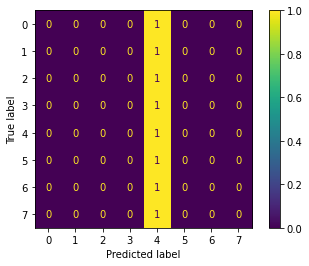

In [17]:
from sklearn.metrics import ConfusionMatrixDisplay

S_arr = S.numpy()
ConfusionMatrixDisplay.from_predictions(y_true=np.arange(BATCH_SIZE), y_pred=np.argmax(S_arr, axis=1))

Indeed, ideally the predictions should be on the diagonal. This means that the "default" space for this metric learning problem is not that good. We are ready to learn a new representation distribution.

# Model definition

In [18]:
class DeepQPEncoder(keras.Model):

    def __init__(self, model_q, model_p):
        super().__init__()
        self.enc = DenseEncoder(model_q, model_p)

    def call(self, inputs, training=False):
        if training:
            # For training we return the similarity matrix
            repr_q, repr_p = self.enc(inputs, training=training)
            S = tf.tensordot(repr_q, tf.transpose(repr_p), axes=1)
            return S
        else:
            # In other cases, we return the representation of the question(s)
            repr_q = self.enc(inputs, training=training)            
            return repr_q

    def train_step(self, data):
        x = data
        y = tf.range(tf.shape(x['questions']['input_ids'])[0])
        with tf.GradientTape() as tape:
            # Obtain similarities
            S = self(x, training=True)
            # Obtain loss value
            loss = self.compiled_loss(y, S)
        # Construct gradients and apply them through the optimizer
        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        # Update and return metrics (specifically the one for the loss value).
        self.compiled_metrics.update_state(y, S)
        return {m.name: m.result() for m in self.metrics}

    def test_step(self, data):
        x = data
        y = tf.range(tf.shape(x['questions']['input_ids'])[0])
        S = self(x, training=True) # We are not really training, but we have to obtain S
        self.compiled_loss(y, S)
        self.compiled_metrics.update_state(y, S)
        return {m.name: m.result() for m in self.metrics}

def create_model(sample, freeze_layers_up_to=5):
    print("Creating BERT models...")
    model_q, model_p =  TFDistilBertModel.from_pretrained('distilbert-base-uncased'), \
                        TFDistilBertModel.from_pretrained('distilbert-base-uncased')

    # Freeze layers 
    for i in range(freeze_layers_up_to): # layers 0 to variable are frozen, successive layers learn
        model_q.distilbert.transformer.layer[i].trainable = False
        model_p.distilbert.transformer.layer[i].trainable = False

    model_q, model_p = ReducedDistilBertModel(model_q), ReducedDistilBertModel(model_p)

    print("Creating Deep Encoder...")
    model = DeepQPEncoder(model_q, model_p)

    print("Compiling...")
    # Compile the model and loss
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=3e-6),
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[keras.metrics.SparseCategoricalAccuracy()]
    )

    print("Testing on some data...")
    # Pass one batch of data to build the model
    model(sample)

    # Return the model
    print("Model created!")
    return model

# Training

Define utility variables and saving paths.

In [19]:
EPOCHS = 100
PATIENCE = 7

Before training, we check if we're using a TPU, in order to create the model within the scope of the strategy.

Then, we train the model.

In [20]:
import datetime

# GPUs and local systems don't need the above specifications. We simply
# create a pattern for the filename and let the callbacks deal with it.
model_name = f'dpr_{BERT_DIMENSIONALITY}'
checkpoint_path = os.path.join(checkpoint_dir, model_name + ".ckpt")
# Workaraound for saving locally when using cloud TPUs
local_device_option = tf.train.CheckpointOptions(
    experimental_io_device="/job:localhost")

if using_TPU:
    # TPU requires to create the model within the scope of the distributed strategy
    # we're using.
    with strategy.scope():
        model = create_model(sample=next(dataset_train.take(1).as_numpy_iterator()),
                             freeze_layers_up_to=3)
else:
    # On TPU we cannot use tensorboard, but on GPU we can
    log_dir = os.path.join(ROOT_PATH, "data", "logs", 
        f"training_dpr_{BERT_DIMENSIONALITY}", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    
    model = create_model(sample=next(dataset_train.take(1).as_numpy_iterator()),
                             freeze_layers_up_to=3)

Creating BERT models...


Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_transform', 'vocab_projector', 'activation_13', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.
Some layers from the model checkpoint at distilbert-base-uncased were no

Creating Deep Encoder...
Compiling...
Testing on some data...
Model created!


In [61]:
if DO_TRAINING:
    if not using_TPU:
        # Tensorboard callback is not available on TPU
        tensorboard_callback = tf.keras.callbacks.TensorBoard(
            log_dir=log_dir,
            histogram_freq=1
        )
    
    # ModelCheckpoint callback is available both on TPU and GPU 
    # with the options parameter
    cp_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath = checkpoint_path,
        verbose=1,
        save_weights_only = True,
        save_best_only = True,
        options=local_device_option
    )

    # Early stopping can be used by both hardware
    es_callback = tf.keras.callbacks.EarlyStopping(
        patience = PATIENCE,
        restore_best_weights=True
    )

    callbacks = [es_callback, cp_callback]
    if not using_TPU:
        # These callback imply saving stuff on local disk, which cannot be 
        # done automatically using TPUs.
        # Therefore, they are only active when using GPUs and local systems
        callbacks.extend([tensorboard_callback])

    # We fit the model
    history = model.fit(
        dataset_train, 
        y=None,
        validation_data=dataset_val,
        epochs=EPOCHS, 
        callbacks=callbacks,
        use_multiprocessing=True,
        initial_epoch=0,
        verbose=1 # Show progress bar
    )

Epoch 1/100


  1%|          | 12/2067 [1:00:42<173:16:00, 303.53s/it]


1017/1017 [==============================] - ETA: 0s - loss: 0.6513 - sparse_categorical_accuracy: 0.7618
Epoch 1: val_loss improved from inf to 0.34698, saving model to /content/drive/MyDrive/Uni/Magistrale/NLP/Project/weights/training_dpr/dpr_768.ckpt
1017/1017 [==============================] - 384s 300ms/step - loss: 0.6513 - sparse_categorical_accuracy: 0.7618 - val_loss: 0.3470 - val_sparse_categorical_accuracy: 0.8755
Epoch 2/100
1017/1017 [==============================] - ETA: 0s - loss: 0.2418 - sparse_categorical_accuracy: 0.9121
Epoch 2: val_loss improved from 0.34698 to 0.26512, saving model to /content/drive/MyDrive/Uni/Magistrale/NLP/Project/weights/training_dpr/dpr_768.ckpt
1017/1017 [==============================] - 274s 270ms/step - loss: 0.2418 - sparse_categorical_accuracy: 0.9121 - val_loss: 0.2651 - val_sparse_categorical_accuracy: 0.9035
Epoch 3/100
1017/1017 [==============================] - ETA: 0s - loss: 0.1769 - sparse_categorical_accuracy: 0.9352
Epoch 3:

The model was trained in 7 (+7 due to patience) epochs on a cloud TPU. It took less than an hour and reached a validation accuracy of 93.52%. We can make a simple test with the same data of before to see if the embedding space is working properly.

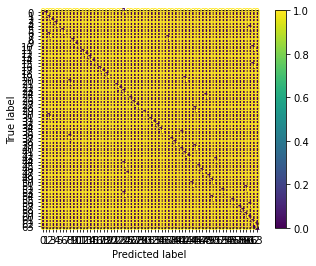

In [62]:
if DO_TRAINING:
    S = model(next(dataset_val.take(1).as_numpy_iterator()), training=True)
    S_arr = S.numpy()
    ConfusionMatrixDisplay.from_predictions(
        y_true=np.arange(BATCH_SIZE), y_pred=np.argmax(S_arr, axis=1))

Training history:

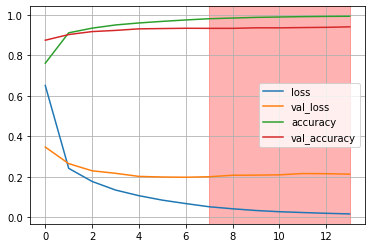

In [63]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.plot(history.history['sparse_categorical_accuracy'], label='accuracy')
plt.plot(history.history['val_sparse_categorical_accuracy'], label='val_accuracy')
plt.legend()
plt.grid()
plt.axvspan(len(history.history['loss'])-7, len(history.history['loss'])-1, color='red', alpha=0.3)

# Evaluation

First of all, we load the weights of the trained model.

In [21]:
# Load the obtained weights
model.load_weights(checkpoint_path, options=local_device_option)

We load the encodings in memory but using the memmap mode because the files are larger than the available RAM. Basically, we are only loading a map of the file on disk in memory and for complex reads we follow this map and read from the disk.

This makes it possible to access the array, even though it will be slower than having the representations on RAM. But in this way we can also enlarge the dimensionality if needed.

In [22]:
representations_dir = os.path.join(datasets_dir, 'representations')
os.makedirs(representations_dir, exist_ok=True)

if OVERRIDE_REPRESENTATIONS:
    test_paragraphs_encodings = np.stack([
            model.enc.model_p(tokenizer_distilbert(
                test_paragraphs[i]['context'], max_length = MAX_SEQ_LEN, 
                return_tensors='tf', truncation = True, padding = 'max_length'
            ))[0,:,:].numpy().astype(np.float32) 
        for i in tqdm(range(len(test_paragraphs)))
    ])
    np.save(os.path.join(representations_dir, 'test_paragraphs_encodings'), test_paragraphs_encodings)
    del test_paragraphs_encodings

test_paragraphs_encodings = np.load(os.path.join(representations_dir, 'test_paragraphs_encodings.npy'), allow_pickle=True)

100%|██████████| 2067/2067 [02:51<00:00, 12.04it/s]


In [23]:
test_paragraphs_encodings.shape, test_paragraphs_encodings.dtype

((2067, 512, 768), dtype('float32'))

We also need to map paragraphs to their position in the encoding matrix.

In [24]:
def get_paragraph_encoding_index(question, dataset):
    art_id, par_id = question['context_id']
    idx = sum([len(dataset[i]['paragraphs']) for i in range(art_id)]) + par_id
    return idx

### Qualitative test

We select some random questions from the test set and see whether the selected paragraph is the correct one.

In [25]:
sample_question = random.choice(test_questions)
question_text = sample_question['qas']['question']
tokenized_question = tokenizer_distilbert(question_text, return_tensors="tf")
paragraph_index = get_paragraph_encoding_index(sample_question, test_paragraphs_and_questions)
print(f"Question: {question_text}")
print(f"Ground truth paragraph: {get_paragraph_from_question(sample_question, test_paragraphs_and_questions)['context']}")
print(f"Ground truth index: {paragraph_index}")
sample_q_repr = model.enc.model_q(tokenized_question)[:,0,:]
print(f"Question representation shape: {sample_q_repr.shape}")
scores = tf.tensordot(sample_q_repr, test_paragraphs_encodings[:,0,:].T, axes=1)
best_par_index = tf.argsort(scores, axis=1, direction='DESCENDING')[0, :5].numpy()
print(f"Top-5 best matching paragraphs have indexes {best_par_index}")
print(f"Top-5 best matching paragraphs:")
for i in range(5):
    print(f"{i})\t{test_paragraphs[best_par_index[i]]['context']}")

Question: How might gravity effects be observed differently according to Newton?
Ground truth paragraph: Newton came to realize that the effects of gravity might be observed in different ways at larger distances. In particular, Newton determined that the acceleration of the Moon around the Earth could be ascribed to the same force of gravity if the acceleration due to gravity decreased as an inverse square law. Further, Newton realized that the acceleration due to gravity is proportional to the mass of the attracting body. Combining these ideas gives a formula that relates the mass () and the radius () of the Earth to the gravitational acceleration:
Ground truth index: 2047
Question representation shape: (1, 768)
Top-5 best matching paragraphs have indexes [2047 2046 2048 2027 2039]
Top-5 best matching paragraphs:
0)	Newton came to realize that the effects of gravity might be observed in different ways at larger distances. In particular, Newton determined that the acceleration of the M

Usually, the correct paragraphs show up in the Top-5 list, or very similar paragraphs appear instead.

### Quantitative test

We can measure the top-1/top-5 accuracy as we've done for the tf-idf baseline.

In [26]:
count_top1 = 0
count_top5 = 0
count_total = len(test_questions)

if RUN_ACCURACY_ANALYSIS:
    def top_5_for_question(tok_q, paragraphs_encodings):
        # Input: a tokenized question
        # Pass the question through the question encoder
        sample_q_repr = model.enc.model_q(tok_q)[:,0,:].numpy()
        # Compute scores with the paragraphs
        scores = np.dot(sample_q_repr, paragraphs_encodings[:,0,:].T)
        # Obtain the best scores and indices
        top5_indices = np.argsort(scores, axis=1)[0, -5:]
        top5_scores = np.sort(scores, axis=1)[0, -5:]
        return top5_indices, top5_scores     

    for i,q in enumerate(tqdm(test_questions)):
        gt_context_id = get_paragraph_encoding_index(q, test_paragraphs_and_questions)
        top5_indices, top5_scores = top_5_for_question(
            tokenizer_distilbert(
                q['qas']['question'], max_length = MAX_SEQ_LEN, 
                return_tensors='tf', truncation = True, padding = 'max_length'
            ), test_paragraphs_encodings
        )
        if gt_context_id == top5_indices[0]:
            count_top1 += 1
        if gt_context_id in top5_indices:
            count_top5 += 1

    top1_score = count_top1 / count_total * 100
    top5_score = count_top5 / count_total * 100

    print(f"\nTop 1 test score: {top1_score:.2f}%,\nTop 5 test score: {top5_score:.2f}%")

100%|██████████| 10570/10570 [25:10<00:00,  7.00it/s]


Top 1 test score: 4.64%,
Top 5 test score: 52.31%


- Top 1 score: 4.64%
- Top 5 score: 52.31%

To have a fair comparison with Tf-Idf, the same model was trained seeing all test paragraphs and reached:

- Top 1 score: 89.04%
- Top 5 score: 97.69%

It looks pretty bad, but these are paragraphs that were not seen in training so the model still has some generalisation capabilities. Also, the selected paragraphs are usually correlated to the question. Finally, the training procedure is bad, because we are only comparing 64 scores at a time, instead of all scores like we do in evaluation: it means that if a negative paragraph that is very similar to the ground truth one is not in the batch, then the job of the network might be too easy.